In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pyproj import Transformer
import random
import shapefile
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool, global_max_pool
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx

# Data Preparation

## Reading Data

In [2]:
dataset = pd.read_csv('restructured_daily.csv')

In [3]:
dataset

,TRGCODE,HOBLINAME,LATITUDE,LONGITUDE,2015-06-01,2015-06-02,2015-06-03,2015-06-04,2015-06-05,2015-06-06,...,2022-09-21,2022-09-22,2022-09-23,2022-09-24,2022-09-25,2022-09-26,2022-09-27,2022-09-28,2022-09-29,2022-09-30
0,99,Yeshwantapura,12.99,77.52,0.5,0.0,5.0,7.0,0.5,0.0,...,0.0,0.0,0.0,8.0,0.0,15.0,0.5,0.0,0.0,6.5
1,101,Sulepeth,17.40,77.35,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,102,Aurad,17.44,76.90,0.0,0.0,0.0,0.0,3.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.5,0.5,22.5,9.5,0.0
3,103,Kamalapur,17.58,76.99,0.0,0.0,0.0,7.5,0.0,0.5,...,0.0,0.0,0.0,0.0,4.0,8.5,0.0,1.0,12.5,0.0
4,104,Mahagaon,17.54,76.88,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.5,17.0,0.0,0.0,2.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3927,7841,Sirsi,14.56,74.83,0.0,0.0,0.0,0.2,3.0,0.0,...,0.5,0.0,6.5,2.5,0.0,0.0,0.0,0.0,0.0,10.5
3928,7842,Sirsi,14.57,74.87,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3929,7843,Sirsi,14.58,74.82,0.0,0.0,0.0,0.5,0.2,0.0,...,2.5,2.5,2.5,1.5,1.5,2.0,1.0,0.0,0.0,3.0
3930,7846,Supa(Joida),15.30,74.54,0.0,0.0,0.0,0.0,0.0,1.3,...,0.0,0.0,1.0,0.5,0.0,0.0,0.0,0.0,0.0,33.0


In [4]:
dataset.describe()

,TRGCODE,LATITUDE,LONGITUDE,2015-06-01,2015-06-02,2015-06-03,2015-06-04,2015-06-05,2015-06-06,2015-06-07,...,2022-09-21,2022-09-22,2022-09-23,2022-09-24,2022-09-25,2022-09-26,2022-09-27,2022-09-28,2022-09-29,2022-09-30
count,3932.000000,3932.000000,3932.000000,3932.000000,3932.000000,3932.000000,3932.000000,3932.000000,3932.000000,3932.000000,...,3932.000000,3932.000000,3932.000000,3932.000000,3932.000000,3932.000000,3932.000000,3932.000000,3932.000000,3932.000000
mean,3626.179552,14.388721,76.273548,3.913708,2.664140,2.071312,6.855061,1.137030,0.687996,0.975203,...,0.198932,0.216531,1.465056,1.000407,0.839013,2.029222,0.135249,1.323957,4.067472,9.582579
std,2277.198160,1.640077,0.986107,8.807838,7.963733,7.354733,12.678925,10.119662,3.563426,3.707525,...,1.216795,1.423734,4.978187,3.153658,4.273468,6.710487,1.571676,6.227718,10.418618,13.886600
min,99.000000,11.650000,74.110000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1498.500000,13.040000,75.480000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3375.500000,14.000000,76.320000,0.500000,0.000000,0.000000,0.800000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,5359.750000,15.760000,77.040000,3.700000,0.700000,0.000000,8.000000,0.200000,0.000000,0.000000,...,0.000000,0.000000,0.500000,0.500000,0.000000,0.500000,0.000000,0.000000,2.000000,14.500000
max,7851.000000,18.390000,78.560000,190.500000,84.000000,100.500000,121.500000,586.000000,52.100000,54.500000,...,24.500000,29.000000,55.500000,65.000000,76.000000,131.000000,73.000000,95.000000,108.000000,149.000000


In [5]:
## In start:stop, stop is excluseive
dataset['MEAN'] = dataset.iloc[:, 4:980].mean(axis=1)
dataset['STD'] = dataset.iloc[:, 4:980].std(axis=1)
dataset['MEDIAN'] = dataset.iloc[:, 4:980].median(axis=1)
dataset['IQR'] = dataset.iloc[:, 4:980].quantile(0.75, axis=1) - dataset.iloc[:, 4:980].quantile(0.25, axis=1)

In [6]:
dataset

,TRGCODE,HOBLINAME,LATITUDE,LONGITUDE,2015-06-01,2015-06-02,2015-06-03,2015-06-04,2015-06-05,2015-06-06,...,2022-09-25,2022-09-26,2022-09-27,2022-09-28,2022-09-29,2022-09-30,MEAN,STD,MEDIAN,IQR
0,99,Yeshwantapura,12.99,77.52,0.5,0.0,5.0,7.0,0.5,0.0,...,0.0,15.0,0.5,0.0,0.0,6.5,4.107070,10.348445,0.00,3.000
1,101,Sulepeth,17.40,77.35,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.851947,8.830068,0.00,1.000
2,102,Aurad,17.44,76.90,0.0,0.0,0.0,0.0,3.5,0.0,...,0.0,0.5,0.5,22.5,9.5,0.0,4.523053,11.894159,0.00,3.500
3,103,Kamalapur,17.58,76.99,0.0,0.0,0.0,7.5,0.0,0.5,...,4.0,8.5,0.0,1.0,12.5,0.0,4.776639,10.767511,0.00,4.000
4,104,Mahagaon,17.54,76.88,0.0,0.0,0.0,0.0,0.0,0.0,...,0.5,17.0,0.0,0.0,2.5,0.0,3.996926,12.301344,0.00,2.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3927,7841,Sirsi,14.56,74.83,0.0,0.0,0.0,0.2,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,10.5,14.738012,24.781632,3.80,18.725
3928,7842,Sirsi,14.57,74.87,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.763422,13.538448,0.00,4.825
3929,7843,Sirsi,14.58,74.82,0.0,0.0,0.0,0.5,0.2,0.0,...,1.5,2.0,1.0,0.0,0.0,3.0,10.823053,20.011957,1.95,12.900
3930,7846,Supa(Joida),15.30,74.54,0.0,0.0,0.0,0.0,0.0,1.3,...,0.0,0.0,0.0,0.0,0.0,33.0,6.812705,15.985495,0.00,6.500


Text(0, 0.5, 'Frequency')

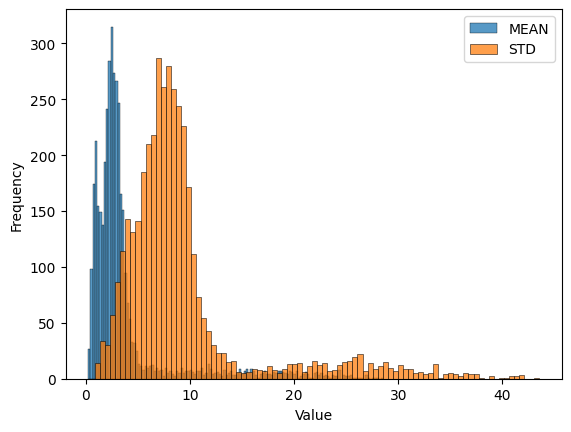

In [7]:
sns.histplot(dataset['MEAN'], label="MEAN")
sns.histplot(dataset['STD'], label="STD")
plt.legend()
plt.xlabel("Value")
plt.ylabel("Frequency")

The randomly selected TRGCODE is 6238


<Axes: ylabel='Count'>

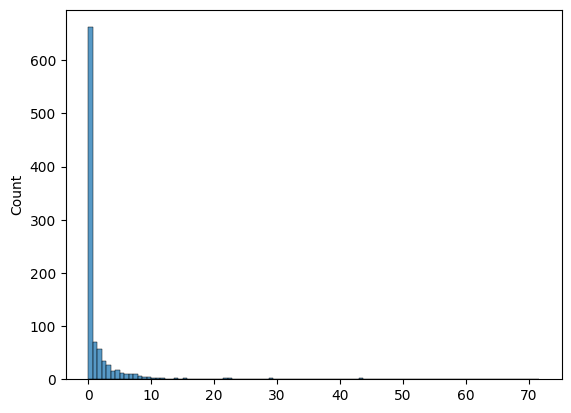

In [8]:
rand_trg = np.random.choice(dataset['TRGCODE'].values)
print(f"The randomly selected TRGCODE is {rand_trg}")

sns.histplot(dataset.loc[dataset['TRGCODE'] == rand_trg].iloc[0, 4:980].values, bins=100)

## Creating Some Useful Data Containers

In [9]:
years = list(range(2015, 2023))

year_wise_dict = {}

year_columns = {
    year: [col for col in dataset.columns if str(year) in str(col)]
    for year in years
}

col_positions = {col: i for i, col in enumerate(dataset.columns)}

## itertuples is faster than iterrows, but it cannot alter the accessed data
for row in dataset.itertuples(index=False):
    trgcode = row.TRGCODE

    year_wise_dict[trgcode] = {}

    for year in years:
        cols = year_columns[year]

        rainfall_vector = [row[col_positions[col]] for col in cols]
        year_wise_dict[trgcode][year] = np.array(rainfall_vector)

In [10]:
cos_sim_dict = {}

for trgcode in dataset['TRGCODE'].unique():

    vectors = [year_wise_dict[trgcode][year] for year in years]
    tensor_data = torch.tensor(vectors, dtype=torch.float32)

    norm_data = torch.nn.functional.normalize(tensor_data, p=2, dim=1)
    sim_matrix = torch.mm(norm_data, norm_data.T)

    cos_sim_dict[trgcode] = sim_matrix

/tmp/ipykernel_2861825/4243304383.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  tensor_data = torch.tensor(vectors, dtype=torch.float32)


In [11]:
all_cos_sims = []

for cos_sim in cos_sim_dict.values():
    cos_sim_no_diag = cos_sim.clone()
    cos_sim_no_diag.fill_diagonal_(float('nan'))
    
    flat_sims = cos_sim_no_diag[~torch.isnan(cos_sim_no_diag)]
    all_cos_sims.append(flat_sims)

## This is the tensor that has all the cosine-similarity scores (exclusing self-similarites) for all TRGCODEs and YEARs
all_cos_sims = torch.cat(all_cos_sims)

In [12]:
global_percentile_dict = {}

for i in range(50, 100, 10):
    global_percentile_dict[i] = torch.quantile(all_cos_sims, i/100).item()

In [13]:
print(global_percentile_dict)

{50: 0.10687559098005295, 60: 0.1373894363641739, 70: 0.1757218986749649, 80: 0.2284267246723175, 90: 0.3193989396095276}


## Generating Labels

In [95]:
threshold = global_percentile_dict[90]
stable_rain = []
unstable_rain = []
trg_means = []

for trgcode in dataset['TRGCODE'].values:
    trg_mean = cos_sim_dict[trgcode].mean() - 0.125
    trg_means.append(trg_mean.item())

    if (trg_mean >= threshold):
        stable_rain.append(trgcode)
    else:
        unstable_rain.append(trgcode)

In [96]:
trg_means

[0.15887540578842163,
 0.10614889860153198,
 0.13752135634422302,
 0.13626736402511597,
 0.08694541454315186,
 0.2370101809501648,
 0.12418700754642487,
 0.11276213824748993,
 0.13639938831329346,
 0.13767775893211365,
 0.11930987238883972,
 0.17198103666305542,
 0.05306616425514221,
 0.13919562101364136,
 0.1452311873435974,
 0.10629427433013916,
 0.11545202136039734,
 0.0898953378200531,
 0.1225966364145279,
 0.20683589577674866,
 0.3290659189224243,
 0.33314961194992065,
 0.16494250297546387,
 0.15339058637619019,
 0.13914412260055542,
 0.13668158650398254,
 0.07202605903148651,
 0.08570416271686554,
 0.11328476667404175,
 0.09072217345237732,
 0.05896808207035065,
 0.1111728847026825,
 0.08079829812049866,
 0.11908227205276489,
 0.06261645257472992,
 0.09248924255371094,
 0.02194233238697052,
 0.10109072923660278,
 0.07347738742828369,
 0.07860331237316132,
 0.1533738374710083,
 0.09859217703342438,
 0.12201374769210815,
 0.057030171155929565,
 0.075055330991745,
 0.073966145515441

<Axes: ylabel='Count'>

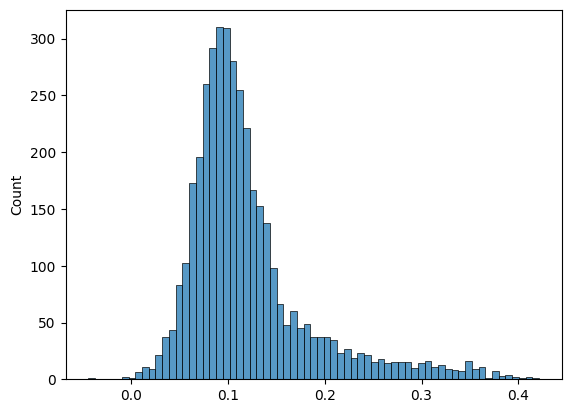

In [97]:
sns.histplot(trg_means)

In [74]:
print(len(stable_rain))
print(len(unstable_rain))

91
3841


In [75]:
stable_dataset = dataset[dataset['TRGCODE'].isin(stable_rain)]
unstable_dataset = dataset[dataset['TRGCODE'].isin(unstable_rain)]

In [76]:
print(len(stable_rain))
print(len(unstable_rain))

91
3841


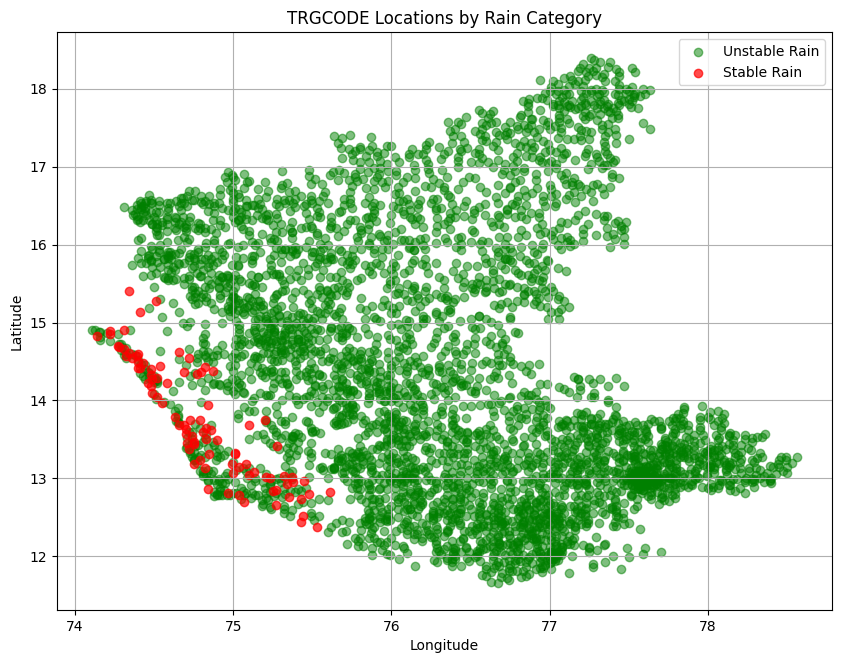

In [77]:
plt.figure(figsize=(10, 7.5))

plt.scatter(unstable_dataset['LONGITUDE'], unstable_dataset['LATITUDE'], color='green', label='Unstable Rain', alpha=0.5)
plt.scatter(stable_dataset['LONGITUDE'], stable_dataset['LATITUDE'], color='red', label='Stable Rain', alpha=0.7)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('TRGCODE Locations by Rain Category')
plt.legend()
plt.grid()
plt.show()

In [78]:
karnataka = shapefile.Reader("Karnataka/State.shp")

transformer = Transformer.from_crs("EPSG:32643", "EPSG:4326", always_xy=True)

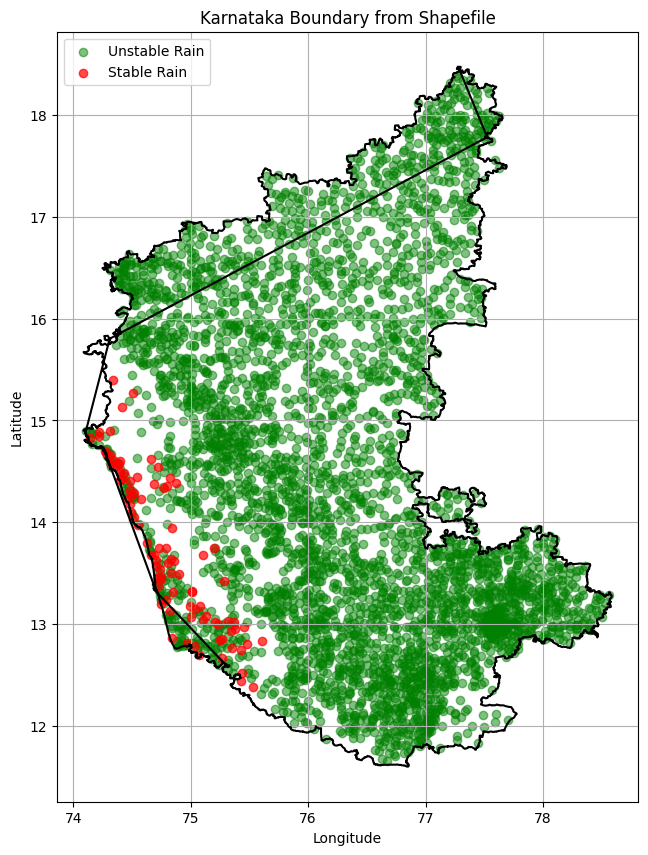

In [79]:
plt.figure(figsize=(7.5, 10))
for shape in karnataka.shapes():
    points = shape.points
    lon_lat = [transformer.transform(x, y) for x, y in points]
    x = [pt[0] for pt in lon_lat]
    y = [pt[1] for pt in lon_lat]
    plt.plot(x, y, 'k')

plt.scatter(unstable_dataset['LONGITUDE'], unstable_dataset['LATITUDE'], color='green', label='Unstable Rain', alpha=0.5)
plt.scatter(stable_dataset['LONGITUDE'], stable_dataset['LATITUDE'], color='red', label='Stable Rain', alpha=0.7)

plt.title("Karnataka Boundary from Shapefile")
plt.legend()
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

## Generating the Graphs

In [80]:
for trgcode in dataset['TRGCODE'].values:
    sum = np.zeros(np.shape(year_wise_dict[trgcode][2022]))

    for year in years:
        sum += year_wise_dict[trgcode][year]

    year_wise_dict[trgcode]['MEAN'] = sum / len(years)

In [81]:
graphs = {}

for trgcode in dataset['TRGCODE'].values:

    edge_list = []

    for i in range(len(years)):
        
        ## 0 is considered as the average node, and each year node has the index (year - 2014)
        edge_list.append([[i + 1], [0]])

        for j in range(len(years)):
            if i < j:
                score = cos_sim_dict[trgcode][i][j]

                if score > threshold:
                    ## Each year node has the index (year - 2014)
                    edge_list.append([[i + 1], [j + 1]])

    edge_list = np.hstack(edge_list)
    edge_list = torch.tensor(edge_list, dtype=torch.long)

    node_features = [year_wise_dict[trgcode]['MEAN']]

    for year in years:
        node_features.append(year_wise_dict[trgcode][year])

    node_features = np.vstack(node_features)
    node_features = torch.tensor(node_features, dtype=torch.float)

    if (trgcode in stable_rain):
        label = torch.tensor([1])
    else: 
        label = torch.tensor([0])

    graph = Data(x=node_features, edge_index=edge_list, y=label)

    graphs[trgcode] = graph

The randomly selected TRGCODE is 6071


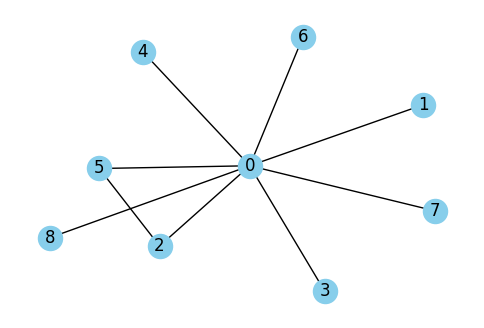

In [82]:
rand_trg = np.random.choice(dataset['TRGCODE'].values)
print(f"The randomly selected TRGCODE is {rand_trg}")

G = to_networkx(graphs[rand_trg], to_undirected=True)

fig, ax = plt.subplots(figsize=(6, 4))
nx.draw(G, ax=ax, with_labels=True, node_size=300, node_color='skyblue')
plt.show()

In [83]:
print(rand_trg in stable_rain)

False


# Training the Model

In [84]:
stratify_labels = [graph.y.item() for graph in graphs.values()]

train_graphs, test_graphs = train_test_split(
    list(graphs.values()),
    test_size=0.2,
    stratify=stratify_labels,
    random_state=3707
)

In [85]:
print(len(train_graphs))
print(len(test_graphs))

3145
787


In [86]:
train_loader = DataLoader(train_graphs, batch_size=128, shuffle=True)
test_loader = DataLoader(test_graphs, batch_size=32, shuffle=True)

In [87]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=[0, 1],
    y=[g.y.item() for g in train_graphs]
)

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

In [88]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(3707)
        self.conv1 = GCNConv(122, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels) ## Same size to refine node embeddings
        self.lin = Linear(hidden_channels, 2)

    def forward(self, x, edge_index, batch):
        ## STEP 1: To obtain node embeddings
        x = self.conv1(x, edge_index) 
        x = F.dropout(x, p=0.5, training=self.training)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = F.dropout(x, p=0.5, training=self.training)

        ## STEP 2: Readout layer
        x = global_max_pool(x, batch) ## Computes batch wise mean of the graphs that have been batched. Returns one feature vector per batch

        ## STEP 3: Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training) ## Dropout is regularization to prevent overfitting
        x = self.lin(x)

        return x

In [89]:
model = GCN(hidden_channels=32)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.5,
    patience=5,
    verbose=True
)

criterion = torch.nn.CrossEntropyLoss(weight=class_weights_tensor) 

def train(train_loader):
    model.train() ## Toggles training mode. Enables dropout, updates running statistics, etc. READ MORE.

    total_loss = 0

    for train_graph in train_loader:
        out = model(train_graph.x.float(), train_graph.edge_index, train_graph.batch) ## A single forward pass
        loss = criterion(out, train_graph.y.long()) ## Compute cross entropy loss
        loss.backward() ## Find the gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step() ## Update parameters based on gradients
        optimizer.zero_grad() ## Clear gradients
        total_loss += loss.item() * train_graph.num_graphs

    return total_loss / len(train_loader.dataset)

def test(loader):
    model.eval() ## Toggles testing behaviour. READ MORE.

    correct = 0

    for graph in loader:
        out = model(graph.x.float(), graph.edge_index, graph.batch)
        prediction = out.argmax(dim=1) ## Use the class with highest probability
        correct += int((prediction == graph.y).sum())
    
    return correct / len(loader.dataset)

/home/prad/.local/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [90]:
losses = list()
train_accuracies = list()
test_accuracies = list()

best_test_accuracy = 0
patience_counter = 0
patience = 10

for epoch in range(1, 120):
    loss = train(train_loader)
    losses.append(loss)
    train_accuracy = test(train_loader)
    test_accuracy = test(test_loader)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    print(f'Epoch: {epoch:03d}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}, Patience Counter: {patience_counter}')

    scheduler.step(test_accuracy)

    if (test_accuracy > best_test_accuracy):
        best_test_accuracy = test_accuracy
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        patience_counter += 1

    if patience_counter > patience:
        print("----- Early stopping triggered -----")
        break

Epoch: 001, Train Accuracy: 0.9781, Test Accuracy: 0.9797, Patience Counter: 0
Epoch: 002, Train Accuracy: 0.9854, Test Accuracy: 0.9835, Patience Counter: 0
Epoch: 003, Train Accuracy: 0.9851, Test Accuracy: 0.9848, Patience Counter: 0
Epoch: 004, Train Accuracy: 0.9676, Test Accuracy: 0.9695, Patience Counter: 0
Epoch: 005, Train Accuracy: 0.9638, Test Accuracy: 0.9657, Patience Counter: 1
Epoch: 006, Train Accuracy: 0.9831, Test Accuracy: 0.9860, Patience Counter: 2
Epoch: 007, Train Accuracy: 0.9835, Test Accuracy: 0.9822, Patience Counter: 0
Epoch: 008, Train Accuracy: 0.9698, Test Accuracy: 0.9708, Patience Counter: 1
Epoch: 009, Train Accuracy: 0.9870, Test Accuracy: 0.9848, Patience Counter: 2
Epoch: 010, Train Accuracy: 0.9758, Test Accuracy: 0.9771, Patience Counter: 3
Epoch: 011, Train Accuracy: 0.9797, Test Accuracy: 0.9809, Patience Counter: 4
Epoch: 012, Train Accuracy: 0.9800, Test Accuracy: 0.9822, Patience Counter: 5
Epoch: 013, Train Accuracy: 0.9901, Test Accuracy: 0

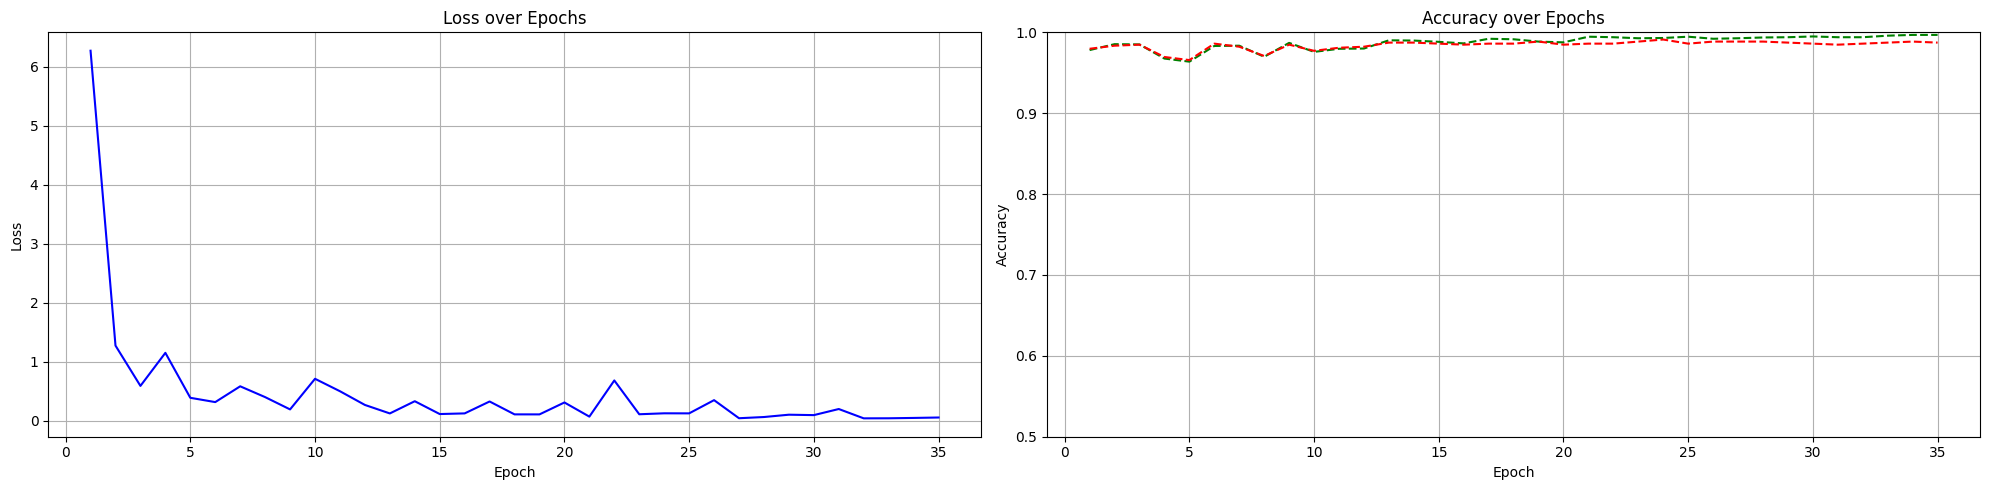

In [91]:
epochs = range(1, len(losses) + 1)

plt.figure(figsize=(20, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, losses, 'b-')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'g--', label='Training Accuracy')
plt.plot(epochs, test_accuracies, 'r--', label='Testing Accuracy')
plt.ylim(0.5, 1)
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()

In [34]:
model.eval()

graph = graphs[123]
with torch.no_grad():
    num_nodes = graph.x.size(0)
    batch = torch.zeros(num_nodes, dtype=torch.long)  # All nodes belong to batch 0
    out = model(graph.x.float(), graph.edge_index, batch)
    prediction = out.argmax(dim=1).item()  # For single graph, get class index

print(prediction)

1
